<a href="https://colab.research.google.com/github/Akechi1412/Phishing-Website-Detection/blob/main/model_training/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Train Phishing Website Detection Model**

## **Connect to Drive and Github responsitory**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github
%cd Phishing-Website-Detection/model_training
!git config --global user.email "nguyenphong10042002@gmail.com"
!git config --global user.name "Akechi1412"
!git fetch origin
!git reset --hard origin/main

/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/Phishing-Website-Detection/model_training
Updating files: 100% (10/10), done.
HEAD is now at 09c9608 Created using Colab


## **Load data**

In [3]:
import h5py

In [4]:
# Load train data
with h5py.File('data/train.h5', 'r') as f:
    url_train = f['url'][:]
    adjacency_train = f['adjacency'][:]
    feature_train = f['feature'][:]
    label_train = f['label'][:]

# Load val data
with h5py.File('data/val.h5', 'r') as f:
    url_val = f['url'][:]
    adjacency_val = f['adjacency'][:]
    feature_val = f['feature'][:]
    label_val = f['label'][:]

# Load test data
with h5py.File('data/test.h5', 'r') as f:
    url_test = f['url'][:]
    adjacency_test = f['adjacency'][:]
    feature_test = f['feature'][:]
    label_test = f['label'][:]

In [5]:
print(label_train)

[1 1 0 ... 0 1 0]


## **Create models functions**

### **Create URL model using Transformer Neutral Network**

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [7]:
@keras.saving.register_keras_serializable()
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.1)
        self.dropout2 = layers.Dropout(0.1)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
        })
        return config

@keras.saving.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "maxlen": self.maxlen,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

In [8]:
def create_url_model(vocab_size, max_word, embed_dim,
                     num_heads, ff_dim, num_transformer_layers):
    inputs = keras.Input(shape=(max_word,), dtype=tf.int32)
    x = PositionalEmbedding(max_word, vocab_size, embed_dim)(inputs)

    for _ in range(num_transformer_layers):
        x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)

    x = layers.GlobalAveragePooling1D()(x)
    url_model = keras.Model(inputs=inputs, outputs=x)
    return url_model

### **Create HTML model using Graph Convolution Network**

In [9]:
!pip install spektral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 58.1 MB/s eta 0:00:00


In [10]:
from spektral.layers import GCNConv, GlobalSumPool

In [11]:
def create_html_model(max_node, feature_dim, gcn_units):
    inputs_adj = keras.Input(shape=(max_node, max_node), dtype=tf.float64)
    inputs_feat = keras.Input(shape=(max_node, feature_dim), dtype=tf.float64)

    gcn_layer = GCNConv(gcn_units, activation='relu')([inputs_feat, inputs_adj])
    pooled_output = GlobalSumPool()(gcn_layer)

    html_model = keras.Model(inputs=[inputs_adj, inputs_feat], outputs=pooled_output)

    return html_model

### **Create full model**

In [12]:
def create_full_model(vocab_size, max_word, embed_dim,
                      num_heads, ff_dim, num_transformer_layers,
                      max_node, feature_dim, gcn_units):
    # URL Model
    url_model = create_url_model(vocab_size, max_word, embed_dim, num_heads, ff_dim, num_transformer_layers)

    # HTML Model
    html_model = create_html_model(max_node, feature_dim, gcn_units)

    # Inputs
    url_inputs = keras.Input(shape=(max_word,), dtype=tf.int32)
    adj_inputs = keras.Input(shape=(max_node, max_node), dtype=tf.float64)
    feat_inputs = keras.Input(shape=(max_node, feature_dim), dtype=tf.float64)

    # Outputs from both models
    url_output = url_model(url_inputs)  # (None, embed_dim)
    html_output = html_model([adj_inputs, feat_inputs])  # (None, gcn_units)

    # Concatenate the outputs (both are 2D now)
    combined = layers.Concatenate()([url_output, html_output])  # (None, embed_dim + gcn_units)

    # Final layers
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    full_model = keras.Model(inputs=[url_inputs, adj_inputs, feat_inputs], outputs=outputs)
    return full_model

## **Train model**

In [13]:
vocab_size = 10000
max_word = url_train.shape[1]
max_node = adjacency_train.shape[1]
feature_dim = 3

model = create_full_model(vocab_size=vocab_size,
                          max_word=max_word,
                          embed_dim=256,
                          num_heads=8,
                          ff_dim=512,
                          num_transformer_layers=2,
                          max_node=max_node,
                          feature_dim=feature_dim,
                          gcn_units=256)

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_filepath = 'models/best_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

history = model.fit([url_train, adjacency_train, feature_train], label_train,
          validation_data=([url_val, adjacency_val, feature_val], label_val),
          epochs=10, batch_size=128,
          callbacks=[checkpoint_callback])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 400, 400)]           0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 400, 3)]             0         []                            
                                                                                                  
 model (Functional)          (None, 256)                  7307776   ['input_4[0][0]']             
                                                                                            

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

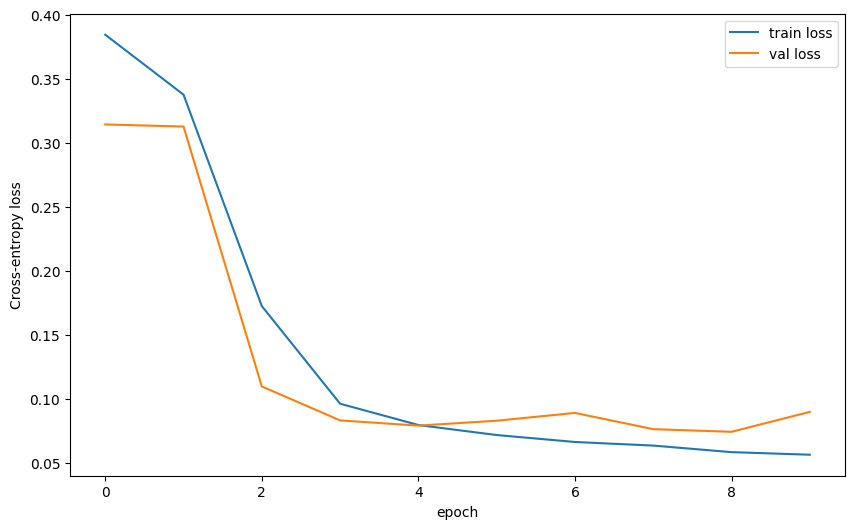

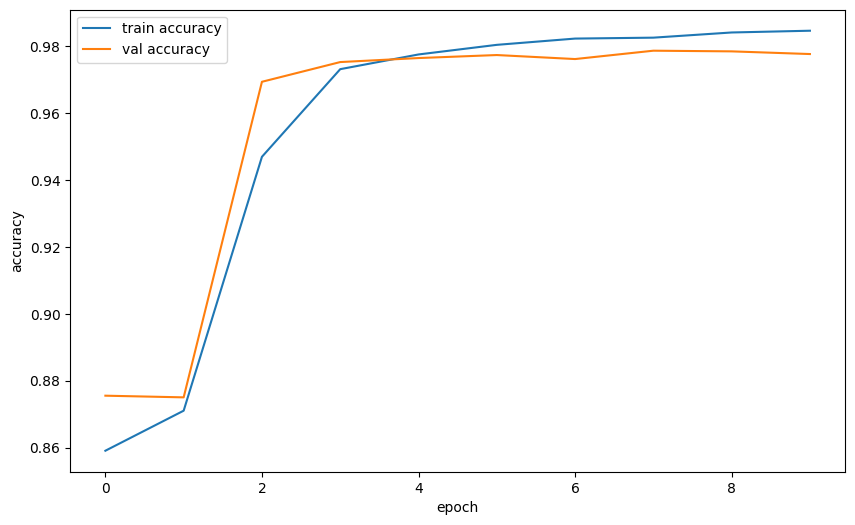

In [16]:
# Plot history loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend()
plt.show()

# Plot history accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## **Test and evaluate model**

In [17]:
best_model = keras.models.load_model(
    'models/best_model.keras',
    custom_objects={'TransformerEncoder': TransformerEncoder,
                    'PositionalEmbedding': PositionalEmbedding,
                    'GCNConv': GCNConv,
                    'GlobalSumPool': GlobalSumPool})

best_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 400, 400)]           0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 400, 3)]             0         []                            
                                                                                                  
 model (Functional)          (None, 256)                  7307776   ['input_4[0][0]']             
                                                                                            

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
y_pred_prob = model.predict([url_test, adjacency_test, feature_test])
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(label_test, y_pred))

313/313 [==============================] - 29s 92ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5000
           1       0.98      0.97      0.98      5000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [21]:
import numpy as np

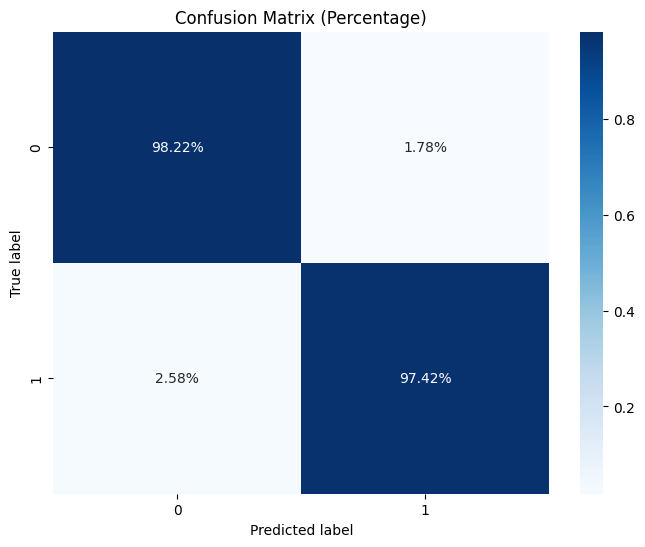

In [22]:
cm = confusion_matrix(label_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap="Blues")
plt.title("Confusion Matrix (Percentage)")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()